In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=50000 # length of data set
P=500 # range to fit acf

In [4]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<ErrorbarContainer object of 3 artists>

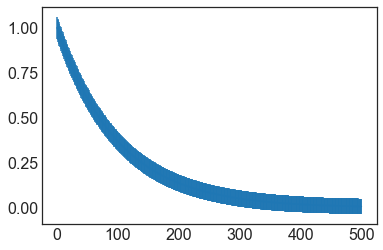

In [5]:
plt.errorbar(t,acf_mean,yerr=acf_std)

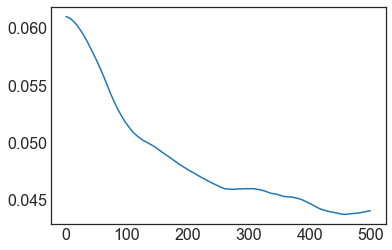

In [6]:
plt.plot(t,acf_std)

In [7]:
acf_all[0].size

500

In [8]:
mod = ExponentialModel()
result_array = None
for i,y in enumerate(acf_all):
    print("***** Iteration ",i," *****")
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = None
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            out.covar[1,1],
                            out.values['amplitude'],
                            out.covar[0,0],
                            out.covar[0,1]])
        print(out.fit_report(min_correl=0.25))
        

    if result_array is None:
        result_array = fit_results
    else:
        result_array = np.vstack((result_array, fit_results))


***** Iteration  0  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 0.84850508
    reduced chi-square = 0.00170383
    Akaike info crit   = -3185.44365
    Bayesian info crit = -3177.01444
[[Variables]]
    decay:      97.9347835 +/- 1.10194975 (1.13%) (init = 100)
    amplitude:  1.04521696 +/- 0.00826403 (0.79%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

***** Iteration  1  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.11800278
    reduced chi-square = 2.3695e-04
    Akaike info crit   = -4171.82758
    Bayesian info crit = -4163.39836
[[Variables]]
    decay:      107.093024 +/- 0.44517477 (0.42%) (init = 100)
    amplitude:

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.08957321
    reduced chi-square = 1.7987e-04
    Akaike info crit   = -4309.65356
    Bayesian info crit = -4301.22434
[[Variables]]
    decay:      121.744796 +/- 0.39991771 (0.33%) (init = 100)
    amplitude:  1.05211499 +/- 0.00241986 (0.23%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.707

***** Iteration  62  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.06276101
    reduced chi-square = 1.2603e-04
    Akaike info crit   = -4487.51466
    Bayesian info crit = -4479.08545
[[Variables]]
    decay:      112.422326 +/- 0.32841998 (0.29%) (init = 100)
    amplitude:  1.02623365 +/- 0.002103

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.38834465
    reduced chi-square = 7.7981e-04
    Akaike info crit   = -3576.23508
    Bayesian info crit = -3567.80586
[[Variables]]
    decay:      130.589326 +/- 0.90074312 (0.69%) (init = 100)
    amplitude:  1.01260834 +/- 0.00487653 (0.48%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.708

***** Iteration  131  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.24628884
    reduced chi-square = 4.9456e-04
    Akaike info crit   = -3803.92920
    Bayesian info crit = -3795.49998
[[Variables]]
    decay:      93.5660092 +/- 0.65017838 (0.69%) (init = 100)
    amplitude:  0.93202518 +/- 0.00455

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.00978882
    reduced chi-square = 0.00202769
    Akaike info crit   = -3098.43344
    Bayesian info crit = -3090.00422
[[Variables]]
    decay:      76.3254323 +/- 0.99069749 (1.30%) (init = 100)
    amplitude:  1.11599189 +/- 0.01017594 (0.91%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

***** Iteration  196  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.02691018
    reduced chi-square = 5.4036e-05
    Akaike info crit   = -4910.92943
    Bayesian info crit = -4902.50022
[[Variables]]
    decay:      93.0738643 +/- 0.20587551 (0.22%) (init = 100)
    amplitude:  0.97033913 +/- 0.00150

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.04453252
    reduced chi-square = 8.9423e-05
    Akaike info crit   = -4659.07188
    Bayesian info crit = -4650.64267
[[Variables]]
    decay:      94.8448295 +/- 0.23985121 (0.25%) (init = 100)
    amplitude:  1.08192708 +/- 0.00192285 (0.18%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

***** Iteration  263  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.20843869
    reduced chi-square = 4.1855e-04
    Akaike info crit   = -3887.35922
    Bayesian info crit = -3878.93000
[[Variables]]
    decay:      96.8521427 +/- 0.60178459 (0.62%) (init = 100)
    amplitude:  0.94311236 +/- 0.00411

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.20270994
    reduced chi-square = 4.0705e-04
    Akaike info crit   = -3901.29364
    Bayesian info crit = -3892.86442
[[Variables]]
    decay:      111.590406 +/- 0.67566049 (0.61%) (init = 100)
    amplitude:  0.89286922 +/- 0.00379363 (0.42%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.705

***** Iteration  329  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.47196991
    reduced chi-square = 9.4773e-04
    Akaike info crit   = -3478.72407
    Bayesian info crit = -3470.29486
[[Variables]]
    decay:      131.404256 +/- 1.04210685 (0.79%) (init = 100)
    amplitude:  0.96841140 +/- 0.00536

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 2.20404402
    reduced chi-square = 0.00442579
    Akaike info crit   = -2708.15712
    Bayesian info crit = -2699.72790
[[Variables]]
    decay:      78.6739974 +/- 1.49103959 (1.90%) (init = 100)
    amplitude:  1.11265219 +/- 0.01481310 (1.33%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

***** Iteration  395  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.32976621
    reduced chi-square = 6.6218e-04
    Akaike info crit   = -3657.98971
    Bayesian info crit = -3649.56050
[[Variables]]
    decay:      112.533020 +/- 0.75556950 (0.67%) (init = 100)
    amplitude:  1.02303557 +/- 0.00481

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.98100615
    reduced chi-square = 0.00196989
    Akaike info crit   = -3112.89233
    Bayesian info crit = -3104.46311
[[Variables]]
    decay:      90.6295722 +/- 1.12214362 (1.24%) (init = 100)
    amplitude:  1.06030741 +/- 0.00922583 (0.87%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

***** Iteration  462  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 0.06888742
    reduced chi-square = 1.3833e-04
    Akaike info crit   = -4440.94486
    Bayesian info crit = -4432.51565
[[Variables]]
    decay:      101.534312 +/- 0.34388497 (0.34%) (init = 100)
    amplitude:  0.97250626 +/- 0.00231

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.06996832
    reduced chi-square = 1.4050e-04
    Akaike info crit   = -4433.16038
    Bayesian info crit = -4424.73117
[[Variables]]
    decay:      96.2687375 +/- 0.33826372 (0.35%) (init = 100)
    amplitude:  0.96906903 +/- 0.00239289 (0.25%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

***** Iteration  529  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.12131585
    reduced chi-square = 2.4361e-04
    Akaike info crit   = -4157.98295
    Bayesian info crit = -4149.55373
[[Variables]]
    decay:      102.046109 +/- 0.47684893 (0.47%) (init = 100)
    amplitude:  0.93316317 +/- 0.00306

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.63907519
    reduced chi-square = 0.00128328
    Akaike info crit   = -3327.17063
    Bayesian info crit = -3318.74142
[[Variables]]
    decay:      93.4573202 +/- 0.89301396 (0.96%) (init = 100)
    amplitude:  1.09244408 +/- 0.00733650 (0.67%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.704

***** Iteration  593  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 0.98782100
    reduced chi-square = 0.00198358
    Akaike info crit   = -3109.43094
    Bayesian info crit = -3101.00172
[[Variables]]
    decay:      77.0664958 +/- 1.02987449 (1.34%) (init = 100)
    amplitude:  1.06704822 +/- 0.01001

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.35178162
    reduced chi-square = 7.0639e-04
    Akaike info crit   = -3625.67639
    Bayesian info crit = -3617.24718
[[Variables]]
    decay:      74.5329109 +/- 0.66137580 (0.89%) (init = 100)
    amplitude:  0.97485978 +/- 0.00607586 (0.62%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.702

***** Iteration  658  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.14659008
    reduced chi-square = 2.9436e-04
    Akaike info crit   = -4063.36162
    Bayesian info crit = -4054.93240
[[Variables]]
    decay:      90.1777519 +/- 0.52526113 (0.58%) (init = 100)
    amplitude:  0.87334877 +/- 0.00357

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.22983694
    reduced chi-square = 4.6152e-04
    Akaike info crit   = -3838.49664
    Bayesian info crit = -3830.06742
[[Variables]]
    decay:      137.967249 +/- 0.72625640 (0.53%) (init = 100)
    amplitude:  0.99840853 +/- 0.00365815 (0.37%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.709

***** Iteration  724  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.12726424
    reduced chi-square = 2.5555e-04
    Akaike info crit   = -4134.04891
    Bayesian info crit = -4125.61970
[[Variables]]
    decay:      92.7809438 +/- 0.38553554 (0.42%) (init = 100)
    amplitude:  1.12499294 +/- 0.00328

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.42557300
    reduced chi-square = 8.5456e-04
    Akaike info crit   = -3530.46344
    Bayesian info crit = -3522.03423
[[Variables]]
    decay:      85.6844735 +/- 0.76007455 (0.89%) (init = 100)
    amplitude:  1.00174951 +/- 0.00624457 (0.62%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

***** Iteration  790  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.04858783
    reduced chi-square = 0.00210560
    Akaike info crit   = -3079.58188
    Bayesian info crit = -3071.15267
[[Variables]]
    decay:      93.1039655 +/- 1.16587498 (1.25%) (init = 100)
    amplitude:  1.06968527 +/- 0.00941

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.58141667
    reduced chi-square = 0.00116750
    Akaike info crit   = -3374.44786
    Bayesian info crit = -3366.01865
[[Variables]]
    decay:      88.2051811 +/- 0.90179170 (1.02%) (init = 100)
    amplitude:  1.00159450 +/- 0.00719696 (0.72%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.703

***** Iteration  855  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.16026454
    reduced chi-square = 3.2182e-04
    Akaike info crit   = -4018.76879
    Bayesian info crit = -4010.33957
[[Variables]]
    decay:      103.410929 +/- 0.46748843 (0.45%) (init = 100)
    amplitude:  1.10174949 +/- 0.00349

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 1.49587124
    reduced chi-square = 0.00300376
    Akaike info crit   = -2901.94965
    Bayesian info crit = -2893.52043
[[Variables]]
    decay:      137.511742 +/- 2.22285446 (1.62%) (init = 100)
    amplitude:  0.83045055 +/- 0.00934685 (1.13%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.709

***** Iteration  920  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.07726264
    reduced chi-square = 1.5515e-04
    Akaike info crit   = -4383.57640
    Bayesian info crit = -4375.14719
[[Variables]]
    decay:      104.157530 +/- 0.39447363 (0.38%) (init = 100)
    amplitude:  0.90999940 +/- 0.00242

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.38153546
    reduced chi-square = 7.6614e-04
    Akaike info crit   = -3585.07980
    Bayesian info crit = -3576.65058
[[Variables]]
    decay:      129.660309 +/- 1.03243822 (0.80%) (init = 100)
    amplitude:  0.87199270 +/- 0.00484962 (0.56%) (init = 1)
[[Correlations]] (unreported correlations are < 0.250)
    C(decay, amplitude) = -0.708

***** Iteration  989  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.52120418
    reduced chi-square = 0.00104659
    Akaike info crit   = -3429.11076
    Bayesian info crit = -3420.68154
[[Variables]]
    decay:      101.696633 +/- 0.91140588 (0.90%) (init = 100)
    amplitude:  1.01017535 +/- 0.00636

/Users/hstrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


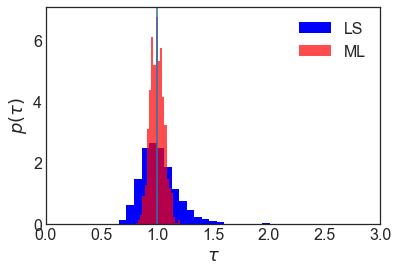

In [9]:
# decay time
plt.figure(facecolor="white")
plt.hist(result_array.T[0],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_Bayes_array.T[2],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0,3))
plt.savefig("tau_dist300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [10]:
phi = 1/result_array.T[3]
theta = 1/result_array.T[1]
omega = 1/result_array.T[4]
dA = np.sqrt(-theta/(phi*theta-omega**2))
dT = np.sqrt(-phi/(phi*theta-omega**2))*delta_t


In [11]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())

Decay time LS mean (real): 1.0141547074680768
Decay time LS std (real): 0.16322139079535763
Decay time LS stderr (real): 0.0007299482504009563
Decay time (mean-true)/stderr: 19.391384882834764
Decay time LS std (fit): 5.036283918646518e-05
Decay time LS std (fit corrected): 5.0001064842214156e-05
Decay time Bayes mean (real): 0.9992300383205097
Decay time Bayes std (real): 0.061219567565266524
Decay time Bayes stderr (real): 0.0002737822292581545
Decay time Bayes std (fit): 0.06351449363327077


/Users/hstrey/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


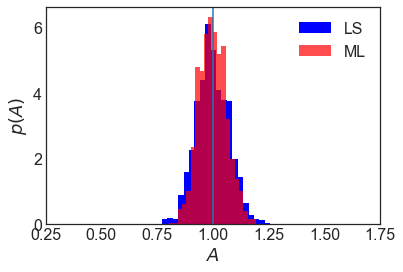

In [12]:
# amplitude
plt.hist(result_array.T[2],normed=True,bins=20,label="LS",color="blue")
plt.hist(result_Bayes_array.T[0],normed=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")

plt.xlim((0.25,1.75))
plt.savefig("A_dist300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [13]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())

Amplitude LS mean (real): 0.998152590033822
Amplitude LS std (real): 0.07356114667854254
Amplitude LS stderr (real): 0.000328975448952108
Amplitude LS std (fit): 0.7206785195141684
Amplitude LS std (fit corrected): 0.716499851510287
Amplitude Bayes mean (real): 0.9990024329675402
Amplitude Bayes std (real): 0.06098900903839772
Amplitude Bayes std (fit): 0.06318251995858944


(1000, 5)
(1000, 4)
(0.4123195278321039, 2.5291513124914114e-42)


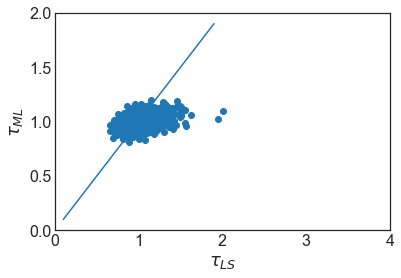

In [14]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(result_array.T[0],result_Bayes_array.T[2])
plt.plot([0.1,1.9],[0.1,1.9])
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(result_array.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.815686829361789, 1.8390086623559414e-239)


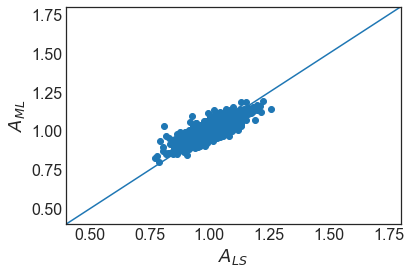

In [15]:
# amplitude correlation
plt.scatter(result_array.T[2],result_Bayes_array.T[0])
plt.plot([0,1.8],[0,1.8])
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))
plt.savefig("A_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [16]:
for i,a,da,t,dt in zip(range(len(result_array.T[2])),result_array.T[2],result_array.T[3],result_array.T[0],result_array.T[1]):
    print(i,a,da,t,dt)

0 1.0452169576917796 1.214293259215129 0.979347834695562 6.829414630627666e-05
1 1.011329871177037 0.1981805796500114 1.0709302440238075 8.714128885027245e-06
2 1.0579760545286718 0.5869847830356164 1.1206409536565192 2.5759318719744734e-05
3 0.9224148383070752 1.0817259157017154 0.9311946784848645 5.2425557208270905e-05
4 0.9116949086699562 0.07335221538790668 0.9042816096898878 3.6828251695192827e-06
5 0.9759232431763911 0.32449643939019657 0.9345343864506834 1.747844068047729e-05
6 0.7716728585393771 0.3175303361835781 1.0770216023350347 8.035917667414891e-06
7 1.1316157144528458 0.592756519659465 0.9974698907083861 3.76661786140968e-05
8 1.0821494957513744 0.2426534785788806 1.1313299489350237 1.092610544848288e-05
9 0.963808777185581 0.0629224899600098 0.906138094089967 3.5162117752768298e-06
10 0.9432441160932481 0.8982990905510195 1.2379039186361407 2.5539684529807536e-05
11 1.1007883412966555 0.4943370594482958 0.926497771733887 3.446860864109801e-05
12 0.9360506467500613 0.457

539 1.0634857951084822 0.5888423816901829 1.1695217253344086 2.3926710135647217e-05
540 0.9315979205316649 1.8857436529499165 1.165509486228873 5.92232466661996e-05
541 1.109427417282891 1.1384927457847243 0.860629698809016 9.344227158621859e-05
542 1.0641024008449733 0.6047748311362597 0.7751154498635934 5.625158223107223e-05
543 1.1743857949519376 0.2413189740251695 0.991409954128889 1.671944132801472e-05
544 1.0983214431208692 0.20443391208695977 1.215499835630714 8.1839601414117e-06
545 1.0139215633890628 1.9787759273776107 1.373870838876549 5.2245844255193376e-05
546 1.0316558222656562 0.1532900671220502 1.1428412907584569 6.145123094797853e-06
547 0.9784320413839824 0.45291690280707864 0.9824066197487192 2.218400124827626e-05
548 1.080080289913838 1.9399709405028147 0.7818097281922164 0.0001827656724824107
549 0.9629981099744298 0.23902360241143158 0.8237118741473445 1.6129805319502972e-05
550 1.0012996750978038 1.3704394529465849 0.9396135777216837 7.685661071577787e-05
551 1.13

965 1.081521296654954 0.06386021175240486 0.8903638488072673 4.654096449968361e-06
966 1.0679936710272888 0.3317997717456745 0.8530404362655167 2.5685553915651254e-05
967 0.8270891753894163 0.1442242935787606 0.9310126531946716 5.621849129706247e-06
968 1.0587534401301495 0.03548639569975494 1.0521203822239937 1.7724795777854027e-06
969 1.0297360869324153 1.773922087584542 0.9421119252548584 0.00010466950404779546
970 0.9809522386972025 0.1058784644137322 1.0425419403470344 4.624493451085236e-06
971 1.0878979871884198 0.07592483625593804 1.0026726959376029 4.412326771031018e-06
972 1.0558580309983565 0.04347338913093735 0.9592286041859817 2.6013813231356044e-06
973 1.0208447876846303 0.16282404537359593 1.0684206677615264 7.328964411506886e-06
974 1.0664409582063383 0.1545066697858738 1.0392645593099212 8.026615767582686e-06
975 0.9315186008632779 0.41044814117581263 1.0704578416258774 1.5325006088417873e-05
976 0.9020570845290212 1.5660002441323833 1.142764900505696 4.8006887753721555

In [17]:
n=209
acf = acf_all[n]
t = np.arange(len(acf))*delta_t
fit = result_array.T[2][n]*np.exp(-t/result_array.T[0][n])
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2)))
print(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2/np.log(10))
print(1/np.sqrt(2*np.pi))
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2)))
print(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2/np.log(10))

3.96E-01
-0.0029951035510042373
0.3989422804014327
0.00E+00
-1820215.261164716


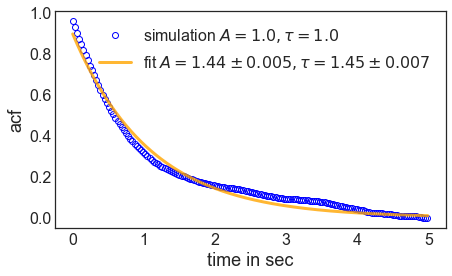

In [18]:
plt.figure(figsize=(7,4))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="blue",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t,fit,linewidth=3,color="orange",label=r"fit $A=1.44\pm0.005,\tau=1.45\pm0.007$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [19]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']
